# TODO

1. Use generic utils to support configuration and both datasets
2. replicate Matan's scenario noise addition + plots 
3. report baseline scores, comparison at the end
4. add retraining lines to plots
5. show drifts on second wave as well
6. add the baseline RMSE drift to plot

# Installs and Download Demo data

In [1]:
# !pip install -q gdown

## Download Data Drift Module and Demo Data

In [2]:
import gdown

# Data Drift Module FROZEN version 28/12/2022 - can also be taken from:
# !git clone https://github.com/mryanivtal/mlops.git
!gdown --id 1Ta-5tC2LBW5CsrlxpomXHtC0obc29oEt
!unzip -n mlops-main.zip
# !cp -n /content/drive/MyDrive/2023/S1/3690_MLOPs/mlops_project/POCs/mlops-main.zip . && 

# Sample dataset CSV file for the Demo
!gdown --id 1UFBAZTQJuNcrQptKWZ8jXFG7kxBBdOLg
!gdown --id 1VfGsdyLDy2hEJKKIPWP6OTkvj5B5cbel
!gdown --id 1jSmwH1ysTdhWEe1KyB7f2xxegpGXda5P


/usr/local/lib/python3.8/dist-packages/gdown/cli.py:127: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1Ta-5tC2LBW5CsrlxpomXHtC0obc29oEt
To: /content/mlops-main.zip
100% 103k/103k [00:00<00:00, 33.2MB/s]
Archive:  mlops-main.zip
a49255d5631c11a9dc153f03150c18205741b274
/usr/local/lib/python3.8/dist-packages/gdown/cli.py:127: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1UFBAZTQJuNcrQptKWZ8jXFG7kxBBdOLg
To: /content/boston_housing.csv
100% 305k/305k [00:00<00:00, 86.3MB/s]
/usr/local/lib/python3.8/dist-packages/gdown/cli.py:127: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file 

# Imports

In [3]:
# generic 
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from xgboost import XGBRegressor
from matplotlib import pyplot as plt
from matplotlib.pyplot import get_cmap
from sklearn.model_selection import train_test_split

import os
import sys 
sys.path.append('mlops-main/data_drift/')
sys.path.append('mlops-main/data_drift/drift_detection/')
sys.path.append('mlops-main/data_drift/helpers/')

# data drift specific
from boston_ds import BostonDS
import helpers.pipeline_utils as PLUtils
from helpers.utils import calc_perf_kpis
from helpers.model_helper import XgbModel
from helpers.data_helper import sample_from_data
from drift_detection.drift_detector import DriftDetector
from drift_detection.drift_testers.ks_drift_tester import KsDriftTester


# Load configuration

In [4]:
selected_dataset = 'BOSTON'
# selected_dataset = 'CLAIMS'
if(selected_dataset=='BOSTON'):
  config_file = 'mlops-main/data_drift/boston_config.json'
  columns_to_modify = ['RM','LSTAT']
elif(selected_dataset=='CLAIMS'):
  config_file = 'mlops-main/data_drift/french_motor_claims_config.json'
  columns_to_modify = ['VehPower','Exposure']
else:
  print('Please set a configuration file to load in \'config_file\'')
  assert(False)

In [5]:
config_dict = PLUtils.load_configuration(config_file=config_file,verbose=True)

Loading configuration from: mlops-main/data_drift/boston_config.json
**********************************************************************
	Key=dataset_name,Value=Boston Housing
	Key=dataset_csv_path,Value=boston_housing.csv
	Key=cat_features,Value=[]
	Key=int_features,Value=['CHAS', 'RAD', 'TAX']
	Key=cont_features,Value=['CRIM', 'ZN', 'INDUS', 'NOX', 'RM', 'AGE', 'DIS', 'PTRATIO', 'B', 'LSTAT']
	Key=target_label,Value=PRICE
**********************************************************************


# Load dataset and Train Test Split

In [6]:
df_full=pd.read_csv(config_dict['dataset_csv_path'])
df_full.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,PRICE
0,0.070457,18.0,2.31,0,0.538650,6.575,64.759142,4.093071,1,296,15.3,396.90,4.98,24.0
1,0.058989,0.0,7.07,0,0.469597,6.421,79.430377,4.963156,2,242,17.8,396.90,9.14,21.6
2,-0.091092,0.0,7.07,0,0.468406,7.185,61.133471,4.985532,2,242,17.8,392.83,4.03,34.7
3,-0.082456,0.0,2.18,0,0.458138,6.998,45.571149,6.060382,3,222,18.7,394.63,2.94,33.4
4,0.037007,0.0,2.18,0,0.458367,7.147,54.259141,6.073643,3,222,18.7,396.90,5.33,36.2


In [7]:
# ============================================================= Initial data setup
x_cat_features  = config_dict['cat_features']
x_int_features  = config_dict['int_features']
x_cont_features = config_dict['cont_features']
y_label         = config_dict['target_label']

X = df_full.drop(y_label,axis=1).copy()
y = df_full[y_label]
print(X.shape,y.shape)
# from entire dataset, choose subset for initial train/test
TRAIN_TEST_SIZE = 550 #1200 takes 1:26 min / With 2000 #each test 2 min / with 500 45 seconds
X_sample, y_sample = sample_from_data(X, y, TRAIN_TEST_SIZE)
X_train, X_test, y_train, y_test = train_test_split(X_sample, y_sample, test_size=0.4, random_state=10)

X_train.shape,y_train.shape,X_test.shape,y_test.shape

(2530, 13) (2530,)


((330, 13), (330,), (220, 13), (220,))

In [8]:
display(X_train.head())

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
832,0.432010,0.0,7.38,0,0.492656,6.312,29.231251,5.449213,5,287,19.6,396.90,6.15
1895,9.736845,0.0,18.10,0,0.672992,6.794,98.200795,1.374327,24,666,20.2,396.90,21.24
1176,2.128847,0.0,19.58,0,0.603844,5.854,91.501365,2.448427,5,403,14.7,395.11,11.64
1002,0.309176,0.0,9.69,0,0.585946,5.390,72.313953,2.782592,6,391,19.2,396.90,21.14
1318,0.190084,33.0,2.18,0,0.472829,7.420,71.852451,3.131758,7,222,18.4,396.90,6.47


# Train and Evaluate a baseline model

### Baseline Model training and evaluation

In [9]:

# ============================================================= Train step
# Build model on train data
# Baseline model
def train_fresh_models(selected_dataset,X_train,y_train):
  '''
  Fresh start for baseline and production models
  (Returns two copies of the baseline model)
  '''
  baseline_model = XGBRegressor(objective='reg:squarederror')
  baseline_model.fit(X_train, y_train)

  saved_model_filename = selected_dataset + "_baseline_model.json"
  baseline_model.save_model(saved_model_filename)

  # Production model (a copy of the baseline initially)
  production_model = XGBRegressor(objective='reg:squarederror')
  production_model.load_model(saved_model_filename)

  return baseline_model,production_model

### Drift detector configuration and train

Create a drift detector and auto-select and fit drift testers based on feature types:
* Numeric features - Kolmogorov–Smirnov tester
* Categorical tests - Chi^2 tester
* All together - KL Divergence (Multivariable) tester

All testers default with pval=0.005, with three conseq. failures.

In Advanced mode - user can select other testers, p-vals, conseq failures.\n
Available testers:
* Kolmogorov–Smirnov
* Chi^2
* Multivariate KL Divergence with autofit
* Multivariate MMD (Max Mean Divergence) with autofit
* Multivatiate KS over PCA


In [10]:
# Create Feature drift detector with all default testers
drift_detector = DriftDetector()
drift_detector.autoselect_testers(x_cont_features, x_int_features, x_cat_features)
drift_detector.fit(X_train)

#One dummy drift detector for baseline model
base_drift_detector = DriftDetector()
base_drift_detector.autoselect_testers(x_cont_features, x_int_features, x_cat_features)
base_drift_detector.fit(X_train)

In [11]:
#TODO move to pipeline utils?
# Initial baseline predction / drift test plan
def get_model_kpi(model,drift_detector,X_test,y_test):
  '''
  Initial baseline predction / drift test plan
  '''
  y_pred = model.predict(X_test)
  kpi_sample = calc_perf_kpis(X_test, y_test, y_pred)
  return kpi_sample

# Common Utility Functions

In [12]:
def init_result_dfs(X_test,y_test,model):
  '''
  Calc and store initial model performance KPIs on test
  '''
  drift_test_results = drift_detector.test_drift(X_test)
  y_pred = model.predict(X_test)
  kpi = calc_perf_kpis(X_test, y_test, y_pred)

  kpi['drift_detected'] = drift_test_results['drift_detected']
  kpi['test_exceptions'] = drift_test_results['test_exceptions']
  kpi_keys = [k for k in kpi.keys()]
  kpi_columns = kpi_keys.append('retrain')
  kpi['retrain'] = False

  perf_kpis_prod = pd.DataFrame(columns=kpi_columns).append(kpi, ignore_index=True)
  perf_kpis_base = pd.DataFrame(columns=kpi_columns).append(kpi, ignore_index=True)

  return perf_kpis_base,perf_kpis_prod

In [13]:
# TODO move to a pipeline utils
def add_artificial_noise_to_data(X_sample,current_batch,columns_to_modify=[],start_drift_at_batch=100):
  '''
  Adds some noise to the data for simulating feature drift
  '''
  # modify data batch to create feature drift
  for c in columns_to_modify:
    X_sample[c] = X_sample[c] + X[c].std() * 0.01 * (current_batch - start_drift_at_batch)
  return X_sample.copy()

In [14]:
#TODO move to pipeline utils
MAX_RETRAIN_PATIENCE = 25# 45
# ============================================================= Runtime step
def run_drift_demo(X,y,number_of_batches = 300, start_drift_at_batch = 100,
                   sample_size = 50,columns_to_modify=[],
                   production_model=None,drift_detector=None,perf_kpis_prod=None,
                   baseline_model=None,baseline_drift_detector=None,perf_kpis_base=None,
                   retrain_on_drift=False):
  '''
  Runs inference in batches, while adding noise to the data to simulate drift
  Checks for data drift and evaluates the given models
  If a baseline model is given both models are being evaluated
  '''
  retrain_patience = 0

  # Runtime loop
  # Sample batch from data (No drift yet)
  for i in tqdm(range(number_of_batches)):
      X_sample, y_sample = sample_from_data(X, y, sample_size)

      # modify data batch to create feature drift
      if (i > start_drift_at_batch):
          X_sample = add_artificial_noise_to_data(X_sample,i,columns_to_modify,start_drift_at_batch)

      # predict
      y_pred = production_model.predict(X_sample)

      # calc RMSE (For demo only, cannot do in real runtime - no labels there
      kpi_sample = calc_perf_kpis(X_sample, y_sample, y_pred)

      # Execute drift test on batch (prod model)
      drift_test_results = drift_detector.test_drift(X_sample)
      kpi_sample['drift_detected'] = drift_test_results['drift_detected']
      kpi_sample['test_exceptions'] = drift_test_results['test_exceptions']
      kpi_sample['retrain'] = False

      #Check for drift 
      if((retrain_on_drift) and (drift_test_results['drift_detected'])):
        if(retrain_patience >= MAX_RETRAIN_PATIENCE):
          # print('retraining...due to drift')
          retrain_patience = 0
          production_model = XGBRegressor(objective='reg:squarederror')
          # production_model.fit(X, y)
          # drift_detector.fit(X)
          production_model.fit(X_sample, y_sample)
          # drift_detector.fit(X_sample)
          
          kpi_sample['retrain'] = True
        else:
          # print('batch:{}, drift detected but skipping retraining...patience is:{}'.format(i,retrain_patience))
          retrain_patience+=1
      perf_kpis_prod = perf_kpis_prod.append(kpi_sample, ignore_index=True)

      # For comparison of two models predict on the same sample (!!!)
      y_pred_base = baseline_model.predict(X_sample)
      kpi_sample_base = calc_perf_kpis(X_sample, y_sample, y_pred_base)

      # Execute drift test on batch (baseline model)
      drift_test_results_base = baseline_drift_detector.test_drift(X_sample)
      kpi_sample_base['drift_detected'] = drift_test_results_base['drift_detected']
      kpi_sample_base['test_exceptions'] = drift_test_results_base['test_exceptions']
      perf_kpis_base = perf_kpis_base.append(kpi_sample_base, ignore_index=True)
    
  return drift_detector,perf_kpis_prod,baseline_drift_detector,perf_kpis_base


In [15]:
# ========================================================================== Plot
def display_run(perf_kpis,drift_detector,simulated_drift_started_at_batch=100,axs=None,title='',baseline_perf_kpis=None):

  # plot RMSE (Loss function) line
  axs.plot(perf_kpis['RMSE'])
  
  if baseline_perf_kpis is not None:
    axs.plot(baseline_perf_kpis['RMSE'])
    
    retrain_index = [r for r in perf_kpis_prod2[perf_kpis_prod2['retrain']==True].index]
    for r in retrain_index:
      # plot vertical line for each retraining
      # axs.axvline(x=r, label='retrain_'+str(r), color='purple', linestyle='dashed')
      axs.axvline(x=r, color='purple', linestyle='dashed')


  # plot vertical line for data drift start point
  axs.axvline(x=simulated_drift_started_at_batch, label='drift_start', color='r', linestyle='dashed')

  # Get drift detector x_history for plots
  x_history = drift_detector.history_df

  # plot vertical line for each tester that fired
  fail_detections = []
  cmap = get_cmap('hsv', 15)

  for i, test_name in enumerate(drift_detector.get_test_names()):
      if x_history[test_name].sum() > 0:
          detection_time = np.where(x_history[test_name] == True)[0].min()
          axs.axvline(x=detection_time, label=test_name, color=cmap(i))

  # Display plot
  axs.legend()
  axs.set_xlabel('batch number')
  axs.set_ylabel('RMSE')
  axs.set_title(title)

In [16]:
def init_test(X_train,y_train,X_test,y_test,
               x_cont_features,x_int_features,x_cat_features,
               selected_dataset):
  '''
  Init all required instances for a fresh test:
  Returns:
  1. 2 Models: baseline and production
  2. 2 drift detectors baseline and production
  3. 2 dataframes to collect the results
  '''

  baseline_model,production_model = train_fresh_models(selected_dataset,X_train,y_train)

  # Create Feature drift detector with all default testers
  drift_detector = DriftDetector()
  drift_detector.autoselect_testers(x_cont_features, x_int_features, x_cat_features)
  drift_detector.fit(X_train)

  #One dummy drift detector for baseline model
  base_drift_detector = DriftDetector()
  base_drift_detector.autoselect_testers(x_cont_features, x_int_features, x_cat_features)
  base_drift_detector.fit(X_train)

  perf_kpis_prod,perf_kpis_base = init_result_dfs(X_test,y_test,production_model)
    
  return drift_detector,perf_kpis_prod,base_drift_detector,perf_kpis_base,baseline_model,production_model

# Runtime 1 - Inference Drift Detection (no retraining)

In [17]:
%%time

# Init fresh start
drift_detector,perf_kpis_prod,base_drift_detector,perf_kpis_base,baseline_model,production_model = \
            init_test(X_train,y_train,X_test,y_test,
                      x_cont_features,x_int_features,x_cat_features,selected_dataset)

start_drift_at_batch = 75
#Baseline and Production comparison
drift_detector,perf_kpis_prod,base_drift_detector,perf_kpis_base = \
      run_drift_demo(X,y,columns_to_modify=columns_to_modify,start_drift_at_batch=start_drift_at_batch,
                   production_model=production_model,drift_detector=drift_detector,perf_kpis_prod=perf_kpis_prod,
                   baseline_model=baseline_model,baseline_drift_detector=base_drift_detector,perf_kpis_base=perf_kpis_base)

  0%|          | 0/300 [00:00<?, ?it/s]

CPU times: user 40.3 s, sys: 935 ms, total: 41.2 s
Wall time: 44 s


## Plot RMSE for Baseline vs. Production

Here they are identical
Drift detected but not handled

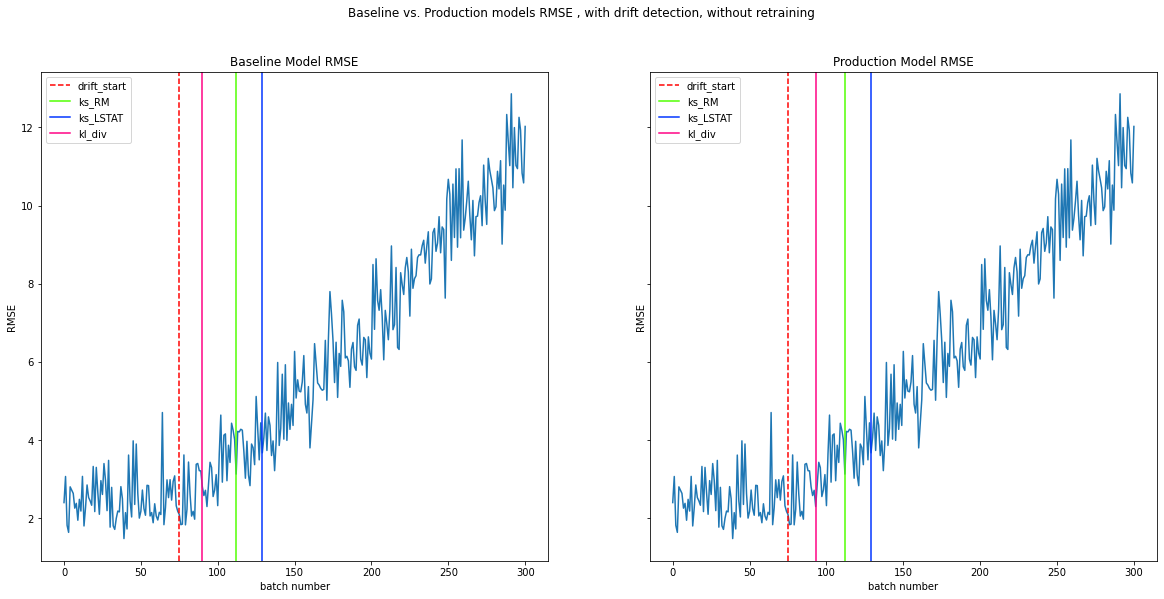

In [18]:
fig, axs = plt.subplots(1,2,figsize=(20, 9),sharey=True)
display_run(perf_kpis_base,base_drift_detector,start_drift_at_batch,axs[0],title='Baseline Model RMSE')
display_run(perf_kpis_prod,drift_detector,start_drift_at_batch,axs[1],title='Production Model RMSE')
plt.suptitle('Baseline vs. Production models RMSE , with drift detection, without retraining')
plt.show()

In [19]:
print('BASELINE')
perf_kpis_base

BASELINE


,R_sq,ajd_R_sq,MAE,MSE,RMSE,drift_detected,test_exceptions,retrain
0,0.921664,0.916721,1.735393,1.735393,2.406441,0.0,[],0.0
1,0.909491,0.876808,2.084541,2.084541,3.073590,0.0,[],NaN
2,0.965947,0.953651,1.335065,1.335065,1.825782,0.0,[],NaN
3,0.915993,0.885657,1.348570,1.348570,1.645120,0.0,[],NaN
4,0.898850,0.862323,1.976330,1.976330,2.808773,0.0,[],NaN
...,...,...,...,...,...,...,...,...
296,-1.697998,-2.672275,10.834773,10.834773,12.255633,1.0,"[ks_RM, ks_LSTAT, kl_div]",NaN
297,-0.773303,-1.413662,10.821711,10.821711,11.921867,1.0,"[ks_RM, ks_LSTAT, kl_div]",NaN
298,-1.062474,-1.807256,9.804482,9.804482,10.827793,1.0,"[ks_RM, ks_LSTAT, kl_div]",NaN
299,0.004665,-0.354761,9.077132,9.077132,10.579371,1.0,"[ks_RM, ks_LSTAT, kl_div]",NaN


In [20]:
print('PRODUCTION')
perf_kpis_prod

PRODUCTION


,R_sq,ajd_R_sq,MAE,MSE,RMSE,drift_detected,test_exceptions,retrain
0,0.921664,0.916721,1.735393,1.735393,2.406441,0.0,[],0.0
1,0.909491,0.876808,2.084541,2.084541,3.073590,False,[],False
2,0.965947,0.953651,1.335065,1.335065,1.825782,False,[],False
3,0.915993,0.885657,1.348570,1.348570,1.645120,False,[],False
4,0.898850,0.862323,1.976330,1.976330,2.808773,False,[],False
...,...,...,...,...,...,...,...,...
296,-1.697998,-2.672275,10.834773,10.834773,12.255633,True,"[ks_RM, ks_LSTAT, kl_div]",False
297,-0.773303,-1.413662,10.821711,10.821711,11.921867,True,"[ks_RM, ks_LSTAT, kl_div]",False
298,-1.062474,-1.807256,9.804482,9.804482,10.827793,True,"[ks_RM, ks_LSTAT, kl_div]",False
299,0.004665,-0.354761,9.077132,9.077132,10.579371,True,"[ks_RM, ks_LSTAT, kl_div]",False


## Summary Results

Should be the same for both

In [21]:
print('Initial Baseline RMSE on test set: {:.4f}'.format(perf_kpis_base.iloc[0]['RMSE']))
print('Initial Production RMSE on test set: {:.4f}'.format(perf_kpis_prod.iloc[0]['RMSE']))
print('*'*50)
print('Final Baseline RMSE on test set: {:.4f}'.format(perf_kpis_base.iloc[-1]['RMSE']))
print('Final Production RMSE on test set: {:.4f}'.format(perf_kpis_prod.iloc[-1]['RMSE']))


Initial Baseline RMSE on test set: 2.4064
Initial Production RMSE on test set: 2.4064
**************************************************
Final Baseline RMSE on test set: 12.0224
Final Production RMSE on test set: 12.0224


# Runtime 2 - Inference Drift Detection (with retraining)

In [22]:
%%time

# Init fresh start
drift_detector2,perf_kpis_prod2,base_drift_detector2,perf_kpis_base2,baseline_model2,production_model2 = \
            init_test(X_train,y_train,X_test,y_test,
                      x_cont_features,x_int_features,x_cat_features,selected_dataset)

start_drift_at_batch = 75
#Baseline and Production comparison
drift_detector2,perf_kpis_prod2,base_drift_detector2,perf_kpis_base2 = \
      run_drift_demo(X,y,columns_to_modify=columns_to_modify,start_drift_at_batch=start_drift_at_batch,
                   production_model=production_model2,drift_detector=drift_detector2,perf_kpis_prod=perf_kpis_prod2,
                   baseline_model=baseline_model2,baseline_drift_detector=base_drift_detector2,
                   perf_kpis_base=perf_kpis_base2,retrain_on_drift=True,sample_size=100)

  0%|          | 0/300 [00:00<?, ?it/s]

CPU times: user 38.9 s, sys: 857 ms, total: 39.8 s
Wall time: 39.5 s


## Plot RMSE for Baseline vs. Production

Drift Detected and automatically handled by retraining

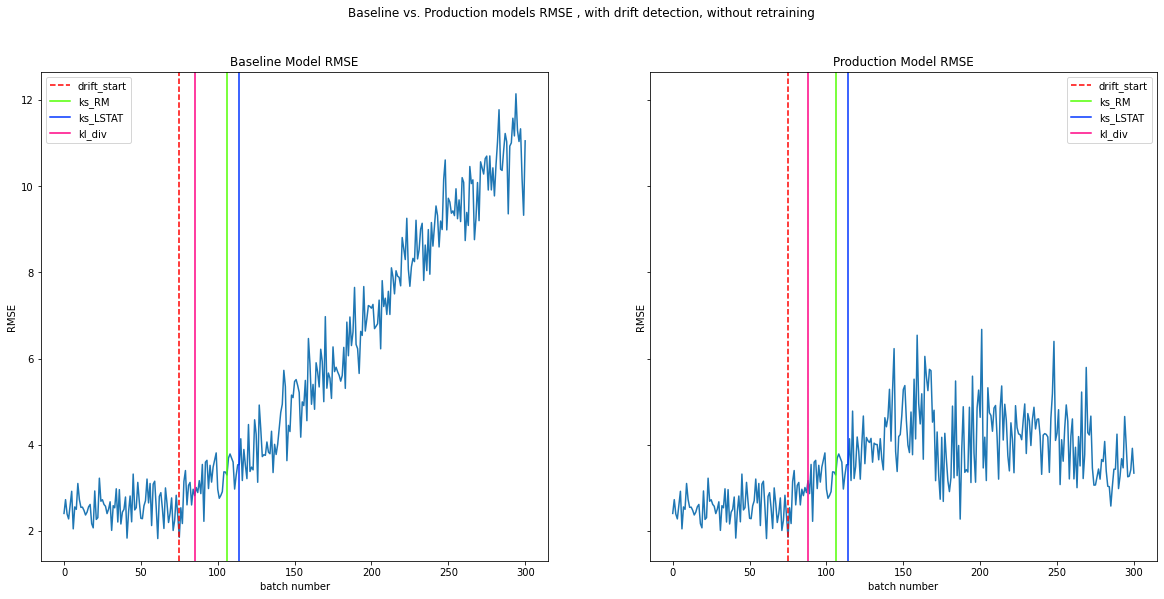

In [23]:
fig, axs = plt.subplots(1,2,figsize=(20, 9),sharey=True)
display_run(perf_kpis_base2,base_drift_detector2,start_drift_at_batch,axs[0],title='Baseline Model RMSE')
display_run(perf_kpis_prod2,drift_detector2,start_drift_at_batch,axs[1],title='Production Model RMSE')
plt.suptitle('Baseline vs. Production models RMSE , with drift detection, without retraining')
plt.show()

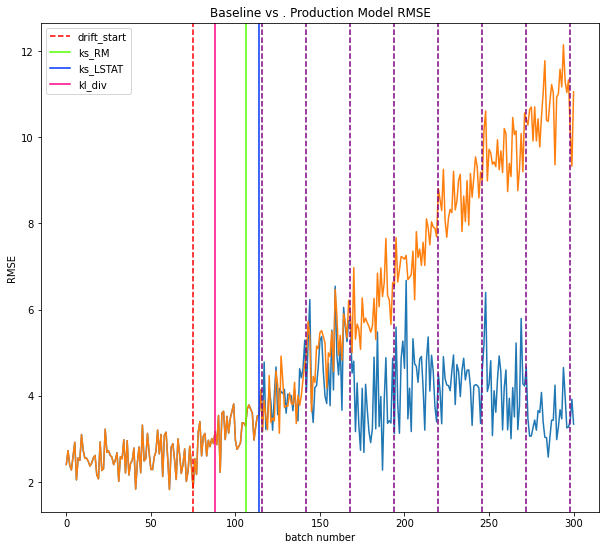

In [24]:
fig, axs = plt.subplots(1,1,figsize=(10, 9))
display_run(perf_kpis_prod2,drift_detector2,start_drift_at_batch,axs,title='Baseline vs . Production Model RMSE',baseline_perf_kpis=perf_kpis_base2)
plt.show()

In [25]:
print('BASELINE'),display(perf_kpis_base2)

BASELINE


,R_sq,ajd_R_sq,MAE,MSE,RMSE,drift_detected,test_exceptions,retrain
0,0.921664,0.916721,1.735393,1.735393,2.406441,0.0,[],0.0
1,0.902657,0.887942,1.866034,1.866034,2.726173,0.0,[],NaN
2,0.917308,0.904808,1.858854,1.858854,2.392261,0.0,[],NaN
3,0.936530,0.926936,1.652211,1.652211,2.279360,0.0,[],NaN
4,0.928147,0.917285,1.757818,1.757818,2.600559,0.0,[],NaN
...,...,...,...,...,...,...,...,...
296,-0.646030,-0.894849,9.617321,9.617321,11.036936,1.0,"[ks_RM, ks_LSTAT, kl_div]",NaN
297,-1.170456,-1.498549,10.090796,10.090796,11.331548,1.0,"[ks_RM, ks_LSTAT, kl_div]",NaN
298,-0.068714,-0.230264,8.913863,8.913863,10.165095,1.0,"[ks_RM, ks_LSTAT, kl_div]",NaN
299,0.225718,0.108676,8.074442,8.074442,9.325604,1.0,"[ks_RM, ks_LSTAT, kl_div]",NaN


(None, None)

In [26]:
print('PRODUCTION'),display(perf_kpis_prod2)

PRODUCTION


,R_sq,ajd_R_sq,MAE,MSE,RMSE,drift_detected,test_exceptions,retrain
0,0.921664,0.916721,1.735393,1.735393,2.406441,0.0,[],0.0
1,0.902657,0.887942,1.866034,1.866034,2.726173,False,[],False
2,0.917308,0.904808,1.858854,1.858854,2.392261,False,[],False
3,0.936530,0.926936,1.652211,1.652211,2.279360,False,[],False
4,0.928147,0.917285,1.757818,1.757818,2.600559,False,[],False
...,...,...,...,...,...,...,...,...
296,0.856765,0.835113,2.352701,2.352701,3.255777,True,"[ks_RM, ks_LSTAT, kl_div]",False
297,0.818995,0.791634,2.409070,2.409070,3.272342,True,"[ks_RM, ks_LSTAT, kl_div]",False
298,0.878782,0.860458,2.579859,2.579859,3.423451,True,"[ks_RM, ks_LSTAT, kl_div]",True
299,0.863346,0.842689,2.369428,2.369428,3.917768,True,"[ks_RM, ks_LSTAT, kl_div]",False


(None, None)

## Summary Results

In [27]:
print('Initial Baseline RMSE on test set: {:.4f}'.format(perf_kpis_base2.iloc[0]['RMSE']))
print('Initial Production RMSE on test set: {:.4f}'.format(perf_kpis_prod2.iloc[0]['RMSE']))
print('*'*50)
print('Final Baseline RMSE on test set: {:.4f}'.format(perf_kpis_base2.iloc[-1]['RMSE']))
print('Final Production RMSE on test set: {:.4f}'.format(perf_kpis_prod2.iloc[-1]['RMSE']))

Initial Baseline RMSE on test set: 2.4064
Initial Production RMSE on test set: 2.4064
**************************************************
Final Baseline RMSE on test set: 11.0526
Final Production RMSE on test set: 3.3417
